# EE-558 - Network tour of Data Science 
## Project: Stack Overflow survey network analysis

### Authors
Romain Choukroun, Matthias Leroy, Alain Milliet, Hector Parmantier

### Question

What's the best developer job like ? (depending on your own definition
of "best")

### Dataset

The dataset provided by [StackOverflow on
Kaggle](https://www.kaggle.com/stackoverflow/so-survey-2017/data) seems
to be a great start. It contains about fifty thousand answers from a
sample of the active StackOverflow population about a lot of questions,
namely 154. This means that we would have a tremendous insight into what
makes a programmer unique, but also can help us to answer a lot of
interesting questions.

### Project

#### Exploratory

Check the distributions of all useful features, outliers, quantiles.
Questions we could answer with the exploration:

-   Does salary equates to happiness/fulfilment in your job ?

-   For users not satisfied with their job, what should they change to
    be more satisfied (use closest correlated neighbor) ?

-   How much is Job Satisfaction linked to education ?

-   Are "gif" people more satisfied with their job compared to "jif"
    people ?
    
#### Metric
Derive metric to measure happiness/fulfillment

#### Pre-processing

Data cleaning, categorize values, check out their distribution,
selecting columns, removing bad values if needed.

#### Feature Extraction

PCA to check which are the features explaining the most variance.

#### Graph Analysis

The graph will be built the following way:

-   Users will be the nodes

-   Correlations (with a threshold) in-between users used as edges

#### Recommender System

The idea here would be to be able to recommend which of a set of users
best represents a set of given goals. To do so, we would simply check
which existing node is the closest to the artificial one that we create
for the chosen features a recruiter is looking for.


In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()
from subprocess import check_output
pd.set_option('display.max_columns', None)

In [2]:
stack = pd.read_csv("data/survey_results_public.csv")
kept_columns = ['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University', 'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'CompanySize', 'CompanyType', 'YearsProgram', 'YearsCodedJob', 'DeveloperType', 'WebDeveloperType', 'NonDeveloperType', 'CareerSatisfaction', 'JobSatisfaction', 'PronounceGIF', 'ProblemSolving', 'BuildingThings', 'LearningNewTech', 'BoringDetails', 'JobSecurity', 'DiversityImportant', 'FriendsDevelopers', 'WorkPayCare', 'ChallengeMyself', 'ImportantBenefits', 'ClickyKeys', 'Overpaid', 'TabsSpaces', 'EducationImportant', 'EducationTypes', 'SelfTaughtTypes', 'WorkStart', 'HaveWorkedLanguage', 'WantWorkLanguage', 'IDE', 'AuditoryEnvironment', 'Methodology', 'EquipmentSatisfiedMonitors', 'StackOverflowSatisfaction', 'StackOverflowFoundAnswer', 'StackOverflowCopiedCode', 'StackOverflowWhatDo', 'Gender', 'HighestEducationParents', 'Race', 'Salary', "ExpectedSalary"]
stack = stack[kept_columns]
stack.set_index("Respondent", inplace=True)
stack.head()

Professional  \
Respondent                                                      
1                                                     Student   
2                                                     Student   
3                                      Professional developer   
4           Professional non-developer who sometimes write...   
5                                      Professional developer   

                         ProgramHobby         Country      University  \
Respondent                                                              
1                           Yes, both   United States              No   
2                           Yes, both  United Kingdom  Yes, full-time   
3                           Yes, both  United Kingdom              No   
4                           Yes, both   United States              No   
5           Yes, I program as a hobby     Switzerland              No   

                                  EmploymentStatus  \
Respondent                                           
1           Not employed, and not looking for work   
2                               Employed part-time   
3                               Employed full-time   
4                               Employed full-time   
5                               Employed full-time   

                                              FormalEducation  \
Respondent                                                      
1                                            Secondary school   
2           Some college/university study without earning ...   
3                                           Bachelor's degree   
4                                             Doctoral degree   
5                                             Master's degree   

                                           MajorUndergrad  \
Respondent                                                  
1                                                     NaN   
2                Computer science or software engineering   
3                Computer science or software engineering   
4           A non-computer-focused engineering discipline   
5                Computer science or software engineering   

                         CompanySize  \
Respondent                             
1                                NaN   
2                 20 to 99 employees   
3           10,000 or more employees   
4           10,000 or more employees   
5                 10 to 19 employees   

                                                  CompanyType  \
Respondent                                                      
1                                                         NaN   
2           Privately-held limited company, not in startup...   
3                                 Publicly-traded corporation   
4           Non-profit/non-governmental organization or pr...   
5           Privately-held limited company, not in startup...   

                YearsProgram     YearsCodedJob  \
Respondent                                       
1               2 to 3 years               NaN   
2              9 to 10 years               NaN   
3           20 or more years  20 or more years   
4             14 to 15 years     9 to 10 years   
5           20 or more years    10 to 11 years   

                                                DeveloperType  \
Respondent                                                      
1                                                         NaN   
2                                                         NaN   
3                                                       Other   
4                                                         NaN   
5           Mobile developer; Graphics programming; Deskto...   

           WebDeveloperType NonDeveloperType  CareerSatisfaction  \
Respondent                                                         
1                       NaN              NaN                 NaN   
2                       NaN              NaN                 NaN   
3 

In [3]:
# We filter out the devs upon some criteria
def row_filter(row):
    if row.Professional not in ["Student", 
                                "Professional developer"]:
        return False
    if row.Professional == "Professional developer":
        if row.EmploymentStatus not in ['Employed part-time',
                                        'Employed full-time',
                                        'Independent contractor, freelancer, or self-employed']:
            return False
        # After checking salary values, we decided to remove the first 5%
        # quantile as they were mostly outliers (values inbetween 0 and 100)
        if row.isnull().Salary or row.Salary < stack.Salary.quantile(0.05):
            return False
        if row.isnull().JobSatisfaction and row.isnull().CareerSatisfaction:
            return False
    else:
        if row.isnull().ExpectedSalary or row.ExpectedSalary < stack.ExpectedSalary.quantile(0.05):
            return False
    return True
    
stack = stack[stack.apply(row_filter, axis=1)]
prof_stack = stack[stack.Professional == "Professional developer"]
stud_stack = stack[stack.Professional == "Student"]

In [4]:
metadata = pd.read_csv("data/survey_results_schema.csv")
metadata

Column  \
0                     Respondent   
1                   Professional   
2                   ProgramHobby   
3                        Country   
4                     University   
5               EmploymentStatus   
6                FormalEducation   
7                 MajorUndergrad   
8                     HomeRemote   
9                    CompanySize   
10                   CompanyType   
11                  YearsProgram   
12                 YearsCodedJob   
13             YearsCodedJobPast   
14                 DeveloperType   
15              WebDeveloperType   
16           MobileDeveloperType   
17              NonDeveloperType   
18            CareerSatisfaction   
19               JobSatisfaction   
20                 ExCoderReturn   
21               ExCoderNotForMe   
22                ExCoderBalance   
23                ExCoder10Years   
24               ExCoderBelonged   
25                 ExCoderSkills   
26            ExCoderWillNotCode   
27                 ExCoderActive   
28                  PronounceGIF   
29                ProblemSolving   
..                           ...   
124         InfluenceRecruitment   
125       InfluenceCommunication   
126       StackOverflowDescribes   
127    StackOverflowSatisfaction   
128         StackOverflowDevices   
129     StackOverflowFoundAnswer   
130      StackOverflowCopiedCode   
131      StackOverflowJobListing   
132     StackOverflowCompanyPage   
133       StackOverflowJobSearch   
134     StackOverflowNewQuestion   
135          StackOverflowAnswer   
136        StackOverflowMetaChat   
137     StackOverflowAdsRelevant   
138  StackOverflowAdsDistracting   
139      StackOverflowModeration   
140       StackOverflowCommunity   
141         StackOverflowHelpful   
142          StackOverflowBetter   
143          StackOverflowWhatDo   
144       StackOverflowMakeMoney   
145                       Gender   
146      HighestEducationParents   
147                         Race   
148                   SurveyLong   
149         QuestionsInteresting   
150           QuestionsConfusing   
151            InterestedAnswers   
152                       Salary   
153               ExpectedSalary   

                                              Question  
0                                 Respondent ID number  
1           Which of the following best describes you?  
2    Do you program as a hobby or contribute to ope...  
3              In which country do you currently live?  
4    Are you currently enrolled in a formal, degree...  
5    Which of the following best describes your cur...  
6    Which of the following best describes the high...  
7    Which of the following best describes your mai...  
8         How often do you work from home or remotely?  
9    In terms of the number of employees, how large...  
10   Which of the following best describes the type...  
11   How long has it been since you first learned h...  
12   For how many years have you coded as part of y...  
13   For how many years did you code as part of you...  
14           Which of the following best describe you?  
15   Which of the following best describes you as a...  
16   For which of the following platforms do you de...  
17                Which of the following describe you?  
18                          Career satisfaction rating  
19                             Job satisfaction rating  
20   You said before that you used to code as part ...  
21   You said before that you used to code as part ...  
22   You said before that you used to code as part ...  
23   You said before that you used to code as part ...  
24   You said before that you used to code as part ...  
25   You said before that you used to code as part ...  
26   You said before that you used to code as part ...  
27   You said before that you used to code as part ...  
28                         How do you pronounce "GIF"?  
29                             I love solving problems  
..                        

# Exploratory Analysis

In this section we will explore different columns of our dataframe to have an idea of what the population we have looks like. We decided to split the professionals and the students such that we can obtain 2 different recommender systems in function of what the recruiter is looking for. For certain features, it makes sense to compare the professionals and the students but for some others it makes more sense to do some statistics on the whole data.

In [63]:
# Function to do some comparison between professionals and students
def plot_stud_prof(prof="", stud="", column="", title=""):
    if column!="":
        prof=prof_stack[column]
        stud=stud_stack[column]
    p = prof.value_counts(normalize=True)[:10]
    v_stud = stud.value_counts(normalize=True)
    s = v_stud.loc[p.index]
    df = pd.DataFrame([p, s])
    df = df.T
    df.columns = ["Professional", "Student"]
    df.plot.bar(figsize=(7,7))
    plt.title(title + ' distribution for Professionals/Students')
    plt.ylabel("Ratio")
    plt.show()

## Professional
In this subsection we want to see the proportion of professionals and students we have in our data

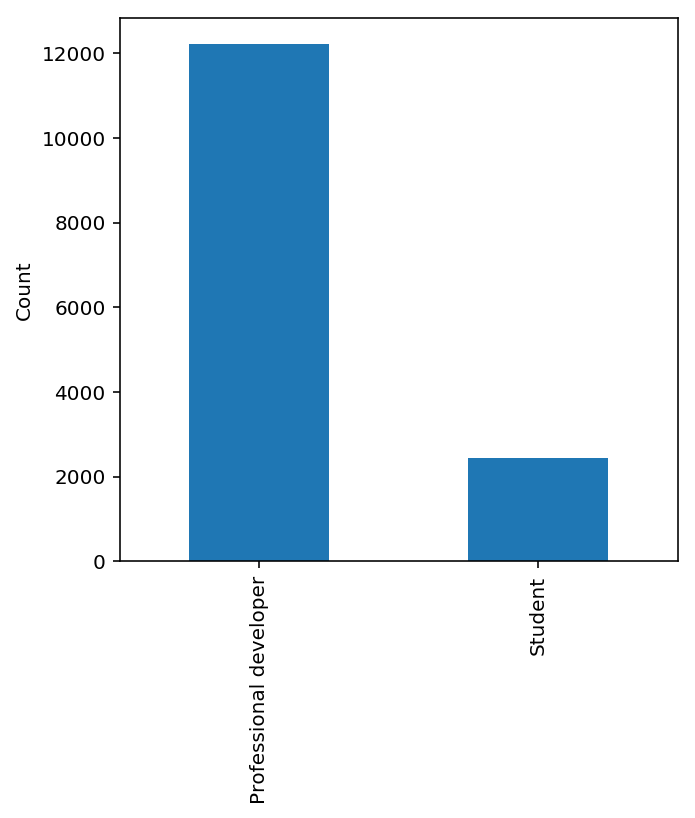

In [64]:
stack['Professional'].value_counts()[0:10].plot(kind='bar',figsize=(5,5))
plt.ylabel("Count")
plt.show()

On this graph, we can see the proportion of professionals and students in our dataset. As we can see, there are a lot more professionals than students.

## Country
We wanted to know from what country the people that answered to the survey come. As we have more professionals than students, we decided to take the 10 countries with the biggest number of professionals and from there we mapped the number of students for thes countries. 

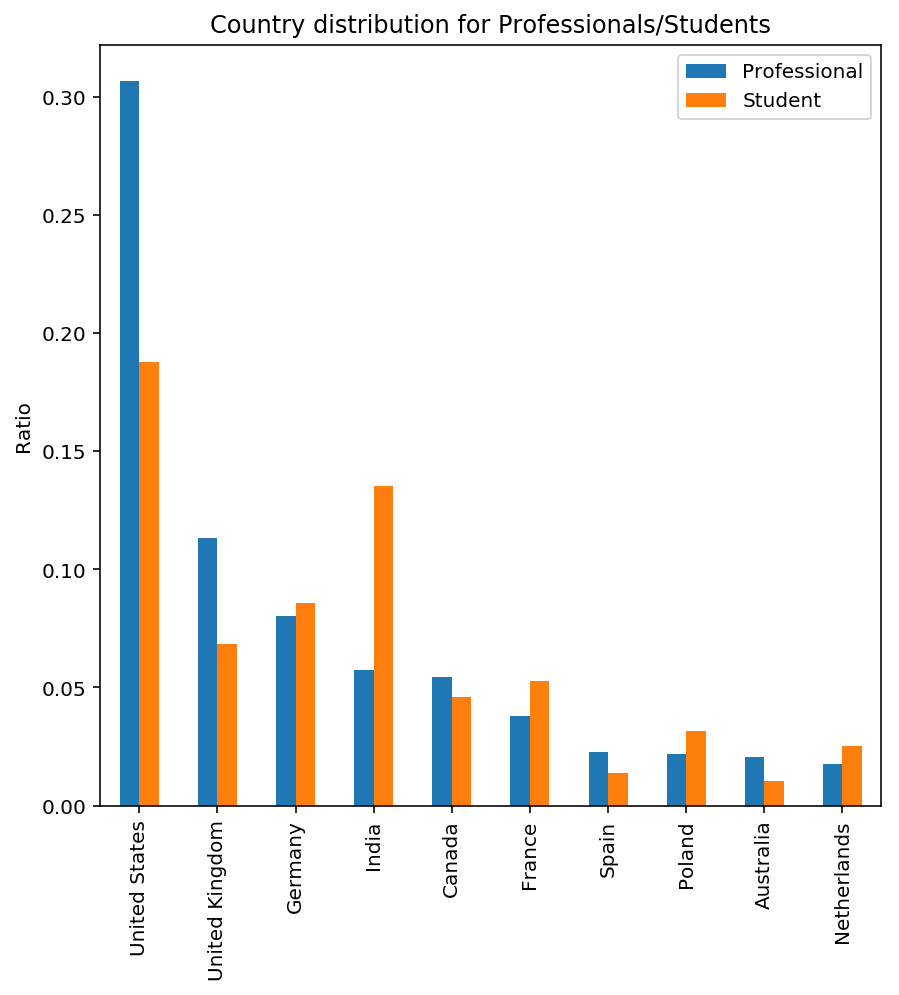

In [65]:
plot_stud_prof(column='Country', title="Country")

On this graph, we can see that the percentage of professionals is not always proportional to the percentage of students in the same country. The United States and India are the two most obvious ones. While 30% of professionals come from the USA, less than 20% of the students come from there. On the other hand, only 5% of professionals in our data come from India while nearly 15% of students come from there.

## Developer Type
This subsection concerns the type of developer we can find in our dataset. 

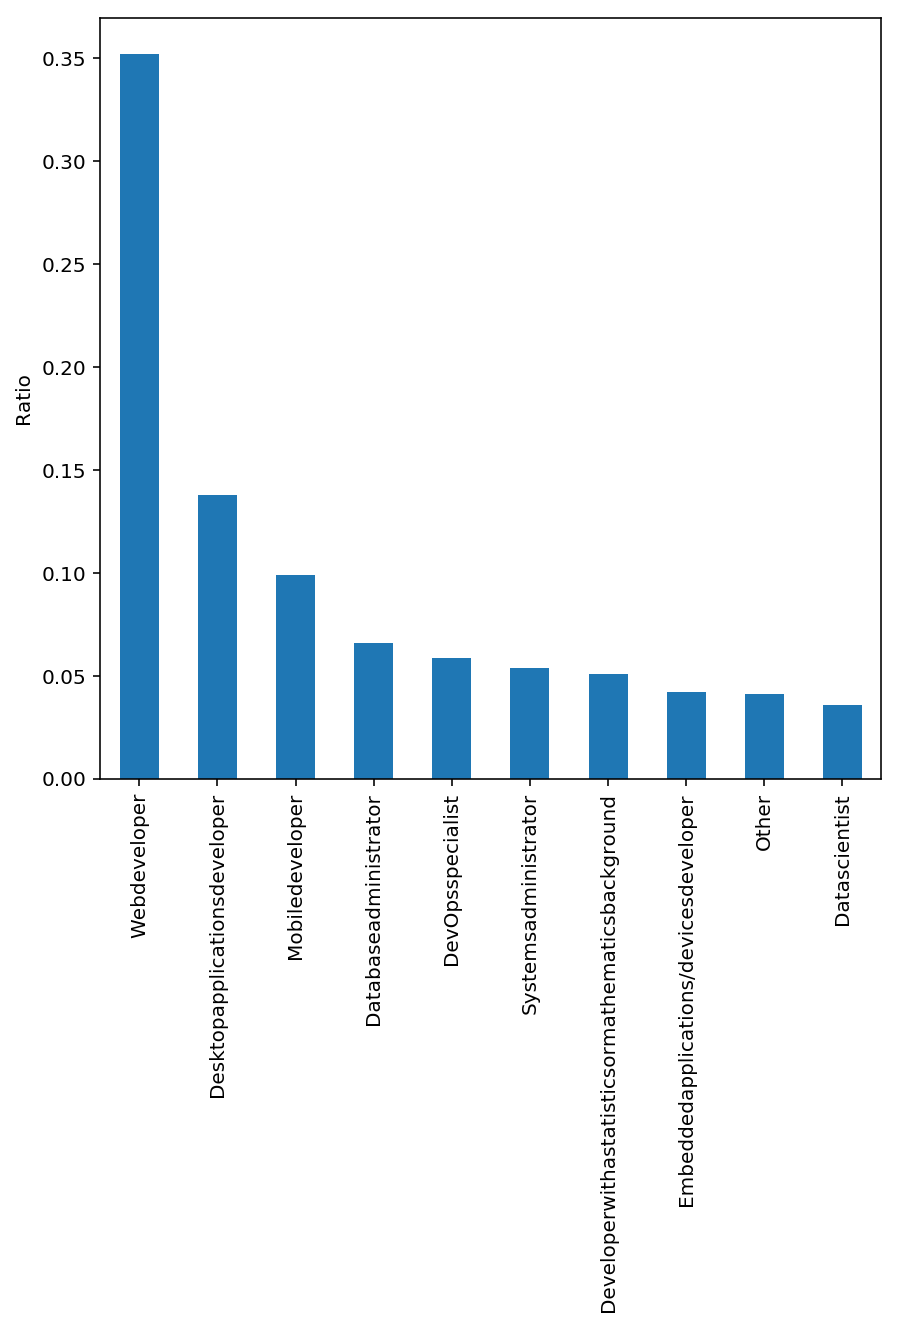

In [67]:
DevTypes = pd.Series([devtype for sublist in [str(devtypes).replace(" ", "").split(";") for devtypes in stack['DeveloperType'].dropna()] for devtype in sublist])
DevTypes.value_counts(normalize=True)[0:10].plot(kind='bar',figsize=(7,7))
plt.ylabel("Ratio")
plt.show()

As an observation, we can say that the major part of the population in our dataset define themself as Web Developper. But this result does not give that much information as there are multiple types of Web developpers.

## Languages
As the previous section was about the type of developper we wanted to see if the programming languages correspond to the these types

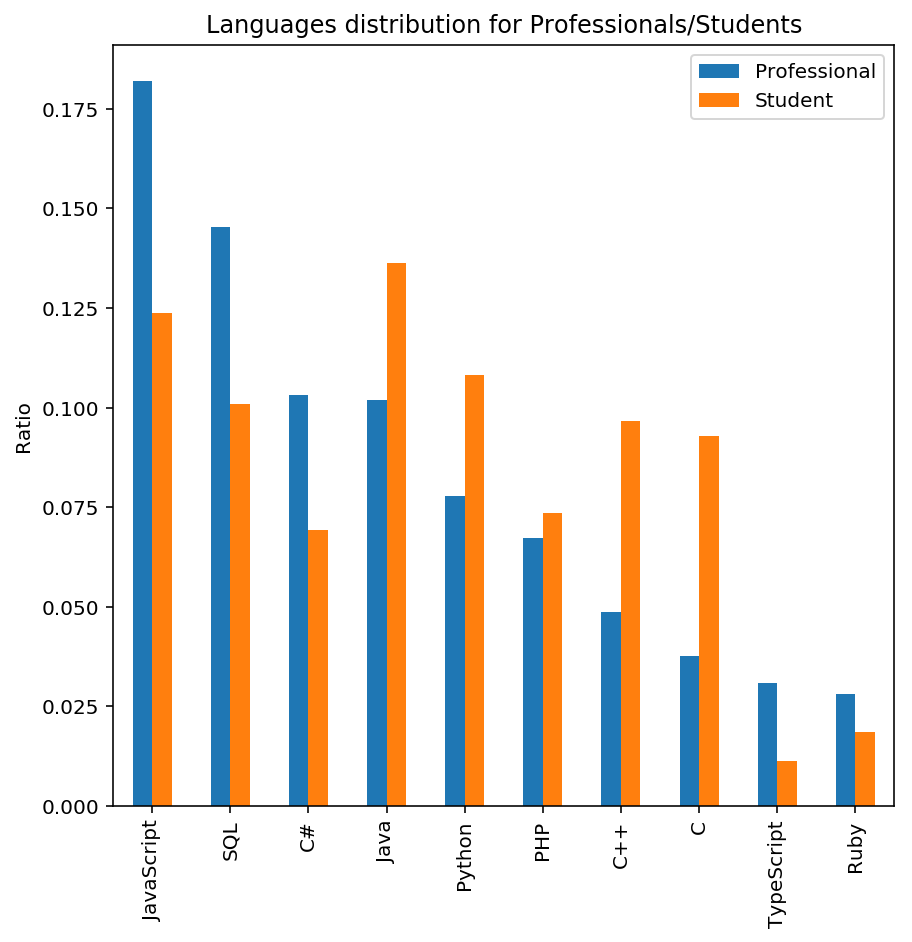

In [68]:
prof_languages = pd.Series([lang for sublist in [str(langs).replace(" ", "").split(";") for langs in prof_stack['HaveWorkedLanguage'].dropna()] for lang in sublist])
stud_languages = pd.Series([lang for sublist in [str(langs).replace(" ", "").split(";") for langs in stud_stack['HaveWorkedLanguage'].dropna()] for lang in sublist])
plot_stud_prof(prof=prof_languages, stud=stud_languages, title="Languages")

It looks like it corresponds pretty well as the most important programming language we find is directly linked to the Web Development.

## Job Satisfaction
In this case, we wanted to see how satisfied of their job the people in our dataset are. We compared the job satisfation with the career satisfaction.

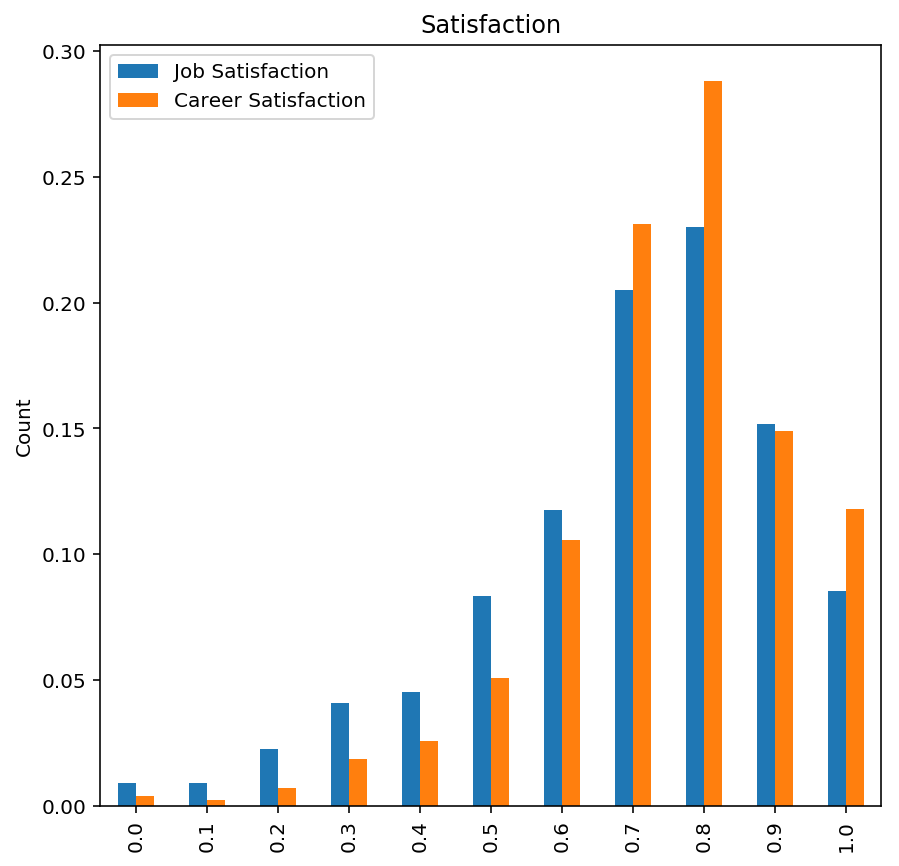

In [69]:
jobSat = stack['JobSatisfaction']/stack['JobSatisfaction'].max()
carrSat = stack['CareerSatisfaction']/stack['CareerSatisfaction'].max()
j = jobSat.value_counts(normalize=True).sort_index()
carr = carrSat.value_counts(normalize=True)
c = carr.loc[j.index]
df = pd.DataFrame([j, c])
df = df.T
df.columns = ["Job Satisfaction", "Career Satisfaction"]
df.plot.bar(figsize=(7,7))
plt.title('Satisfaction')
plt.ylabel("Count")
plt.show()

It is pretty clear on the graph above that the job satisfaction and the career satisfaction are directly linked. To remove all bias such as a person that votes 4 for the job and 8 for the career while another person votes 8 for the job and 4 for the career, we decided to look at the difference between these values and see if we have a lot of people having that much difference in their satisfactions.

In [70]:
satisfaction = stack[['JobSatisfaction','CareerSatisfaction']]

In [71]:
satisfaction['Difference']= np.abs(satisfaction['JobSatisfaction']-satisfaction['CareerSatisfaction'])

C:\Users\Alain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [72]:
satisfaction['Difference'].describe()

count    12210.000000
mean         1.175594
std          1.352746
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: Difference, dtype: float64

As we can see, in general people give approximately the same satisfaction score to their job and to their career. It means that the distribution seen above is correct.

## Diversity Important
In this section we will analyze if professionals and students give the same importance to the diversity at their job.

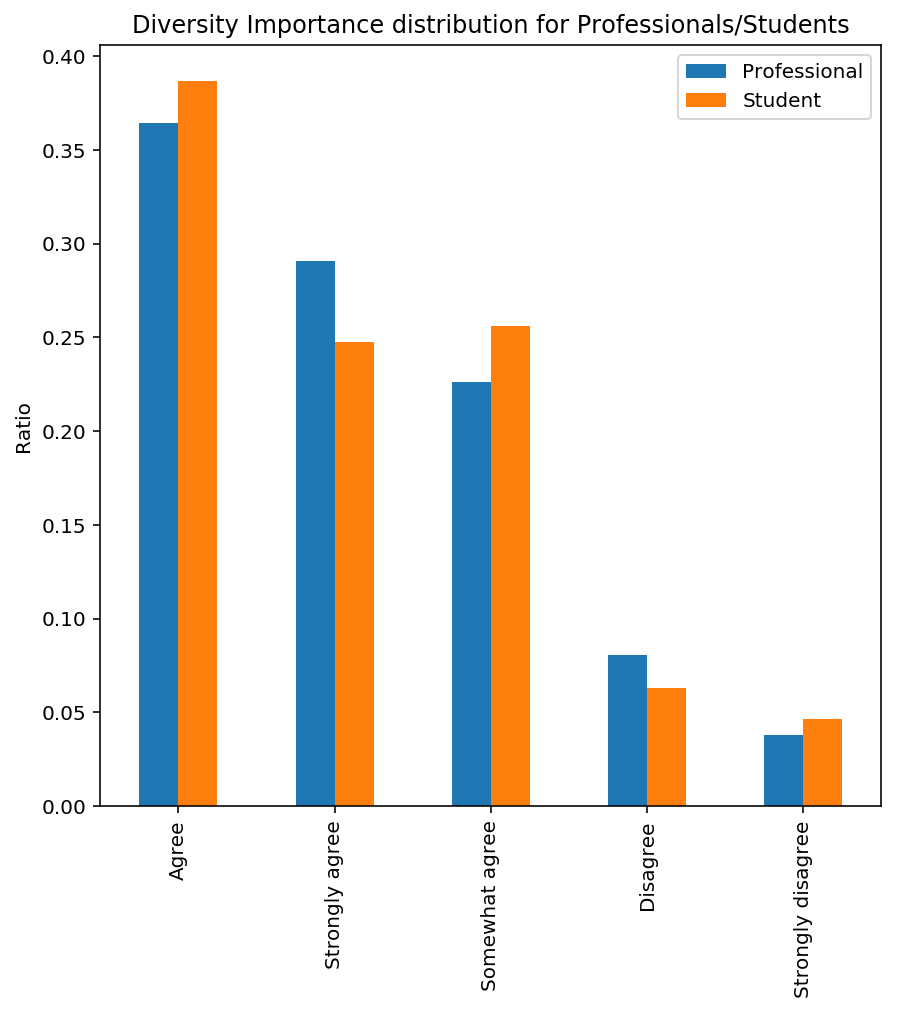

In [73]:
plot_stud_prof(column='DiversityImportant', title="Diversity Importance")

We can pretty easily see that the two distributions are really close and it seems to not be different between professionals and students

# SEPARATION

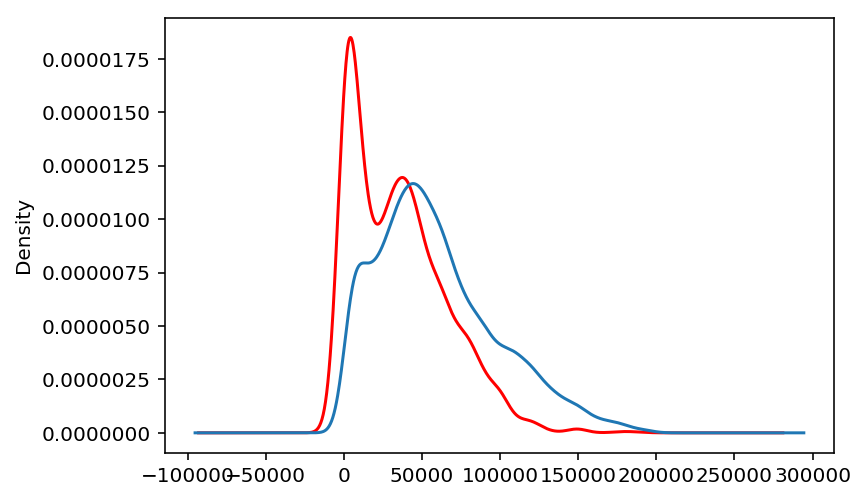

In [74]:
stud_stack.ExpectedSalary.plot.kde(color='r')
prof_stack.Salary.plot.kde()
plt.show()

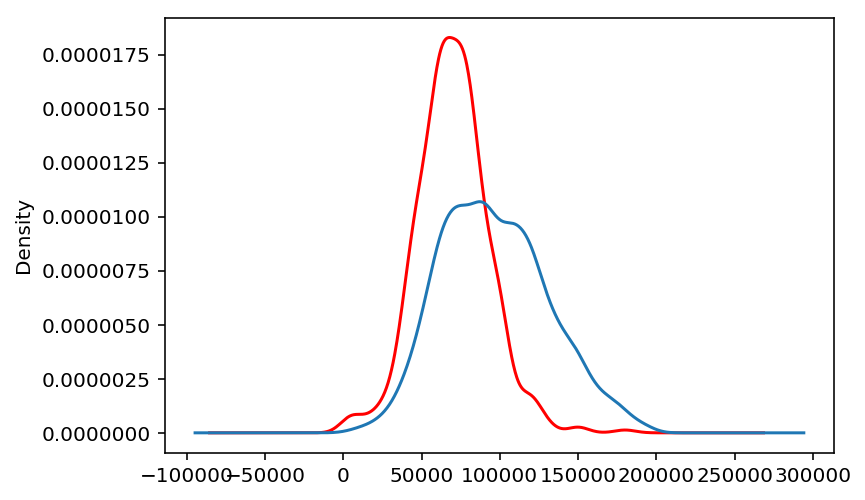

In [75]:
stud_stack[stud_stack.Country == "United States"].ExpectedSalary.plot.kde(color='r')
prof_stack[prof_stack.Country == "United States"].Salary.plot.kde()
plt.show()

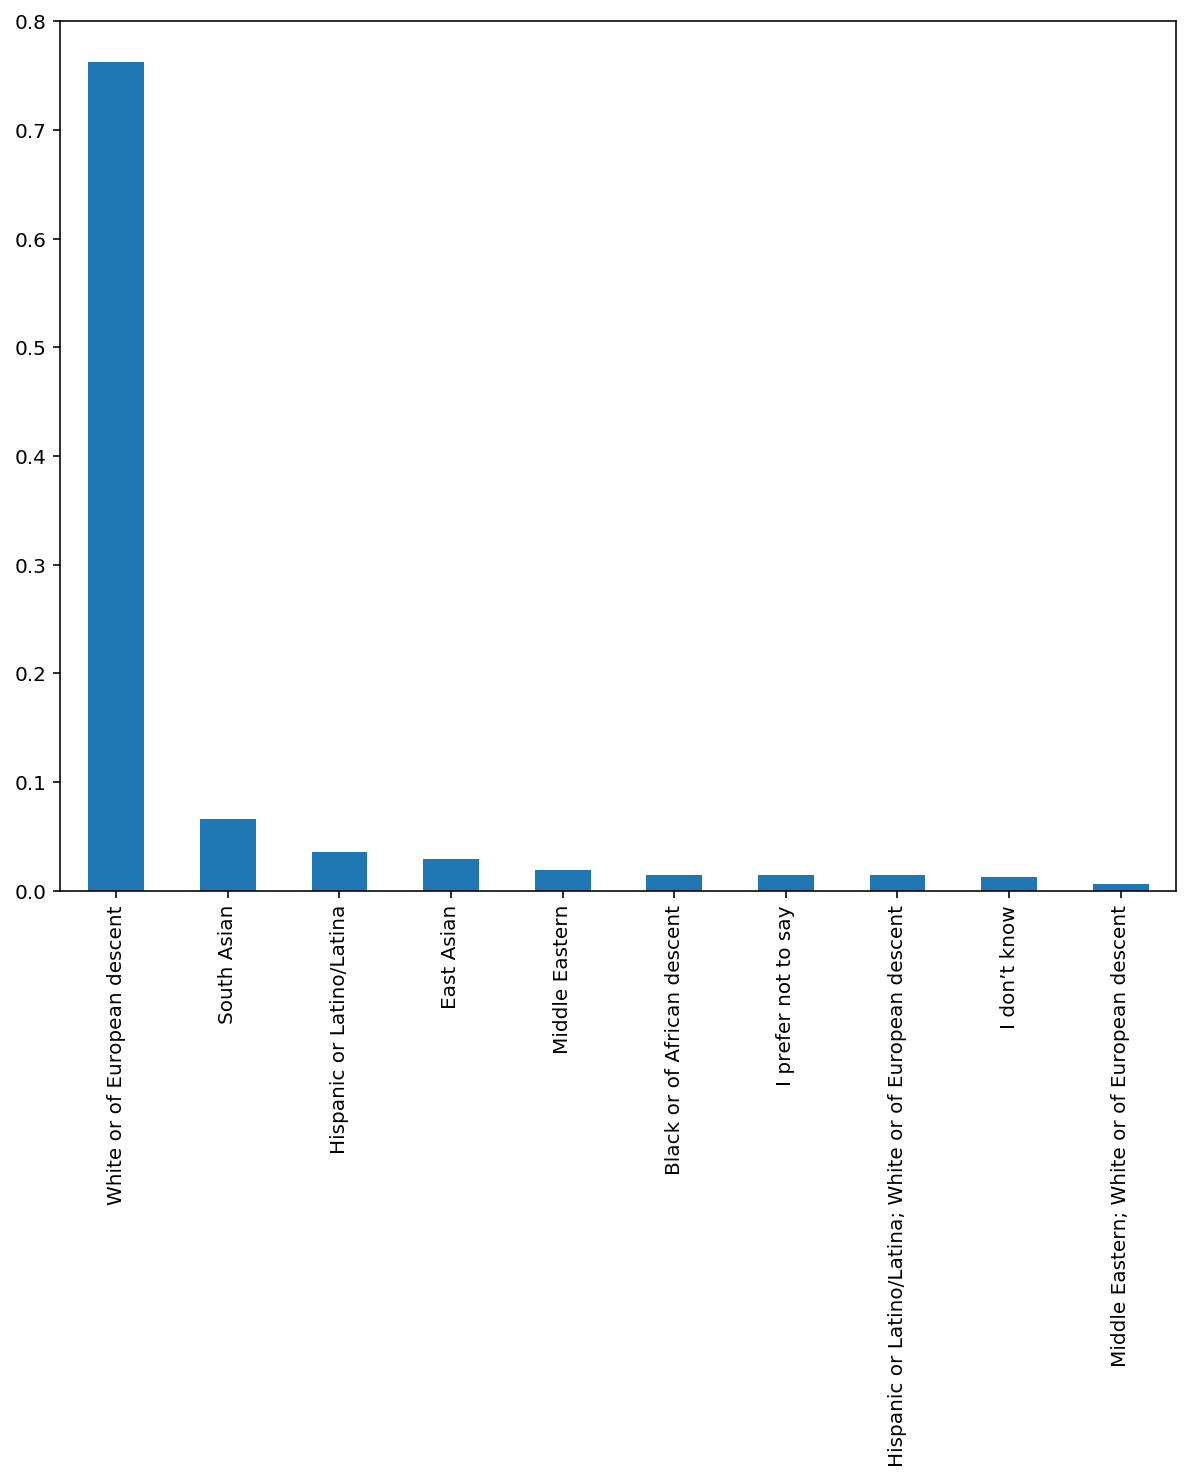

In [76]:
stack.Race.value_counts(normalize=True)[0:10].plot(kind='bar',figsize=(10,8))
plt.show()

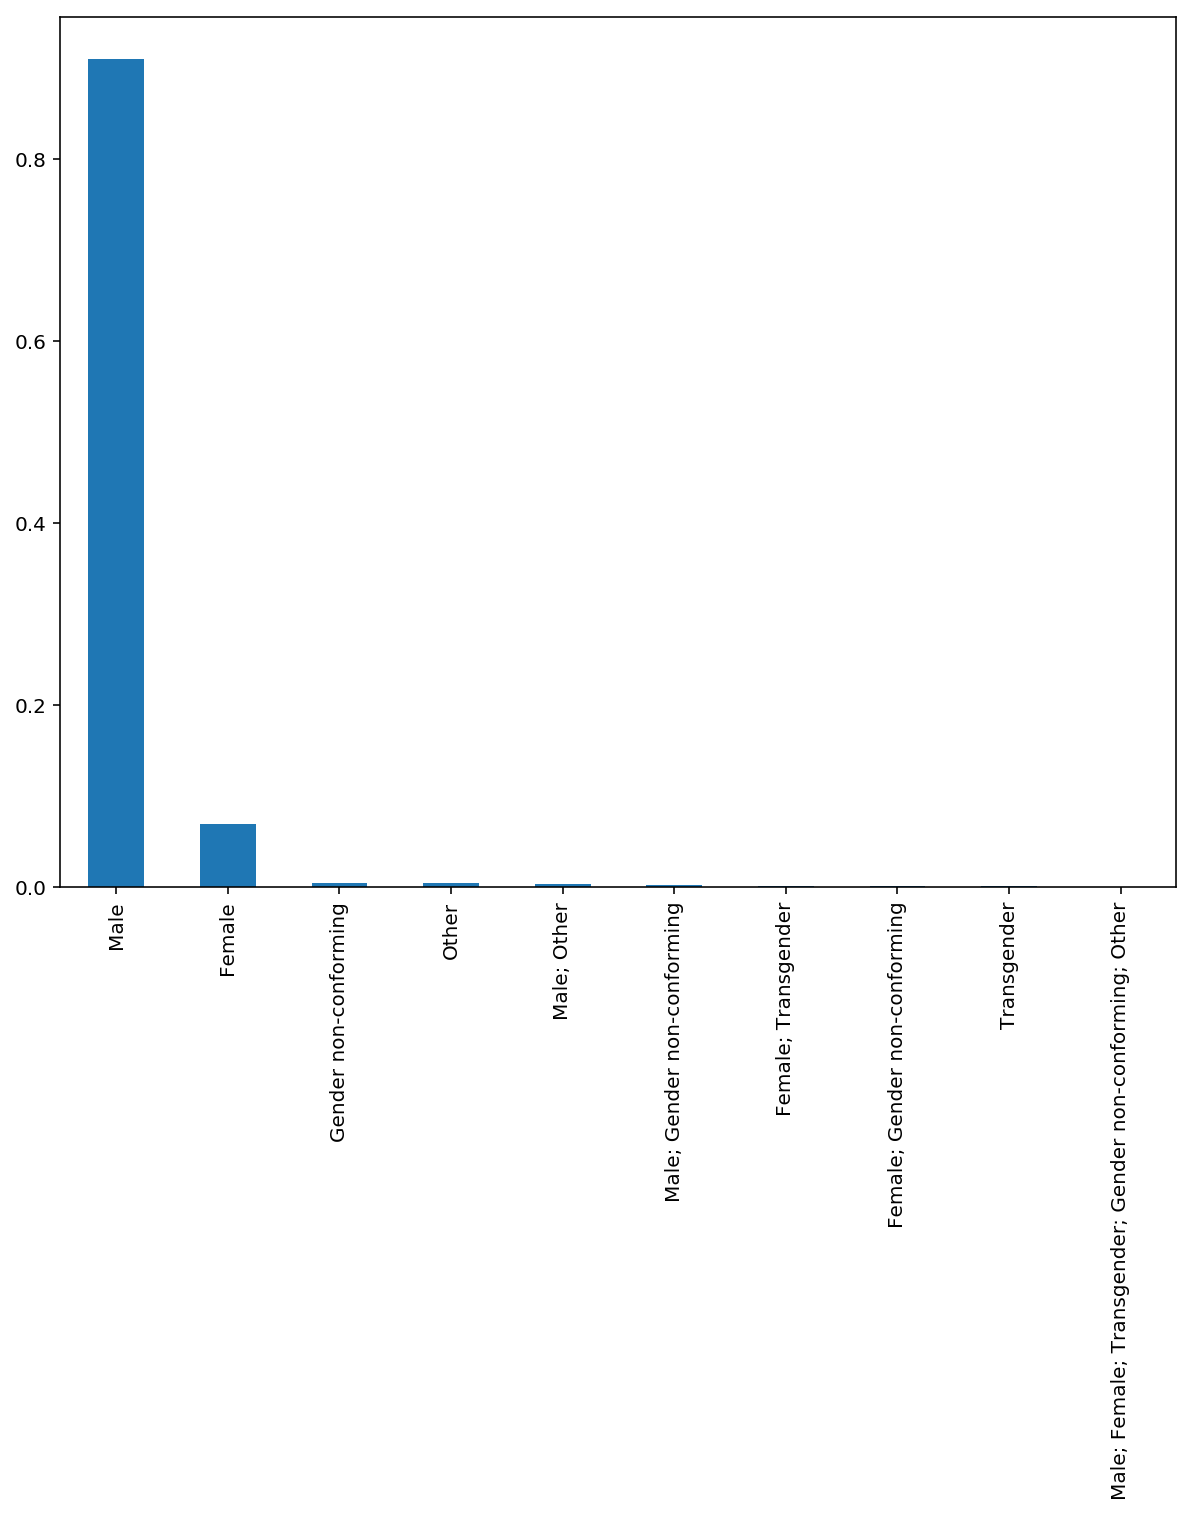

In [77]:
stack.Gender.value_counts(normalize=True)[0:10].plot(kind='bar',figsize=(10,8))
plt.show()

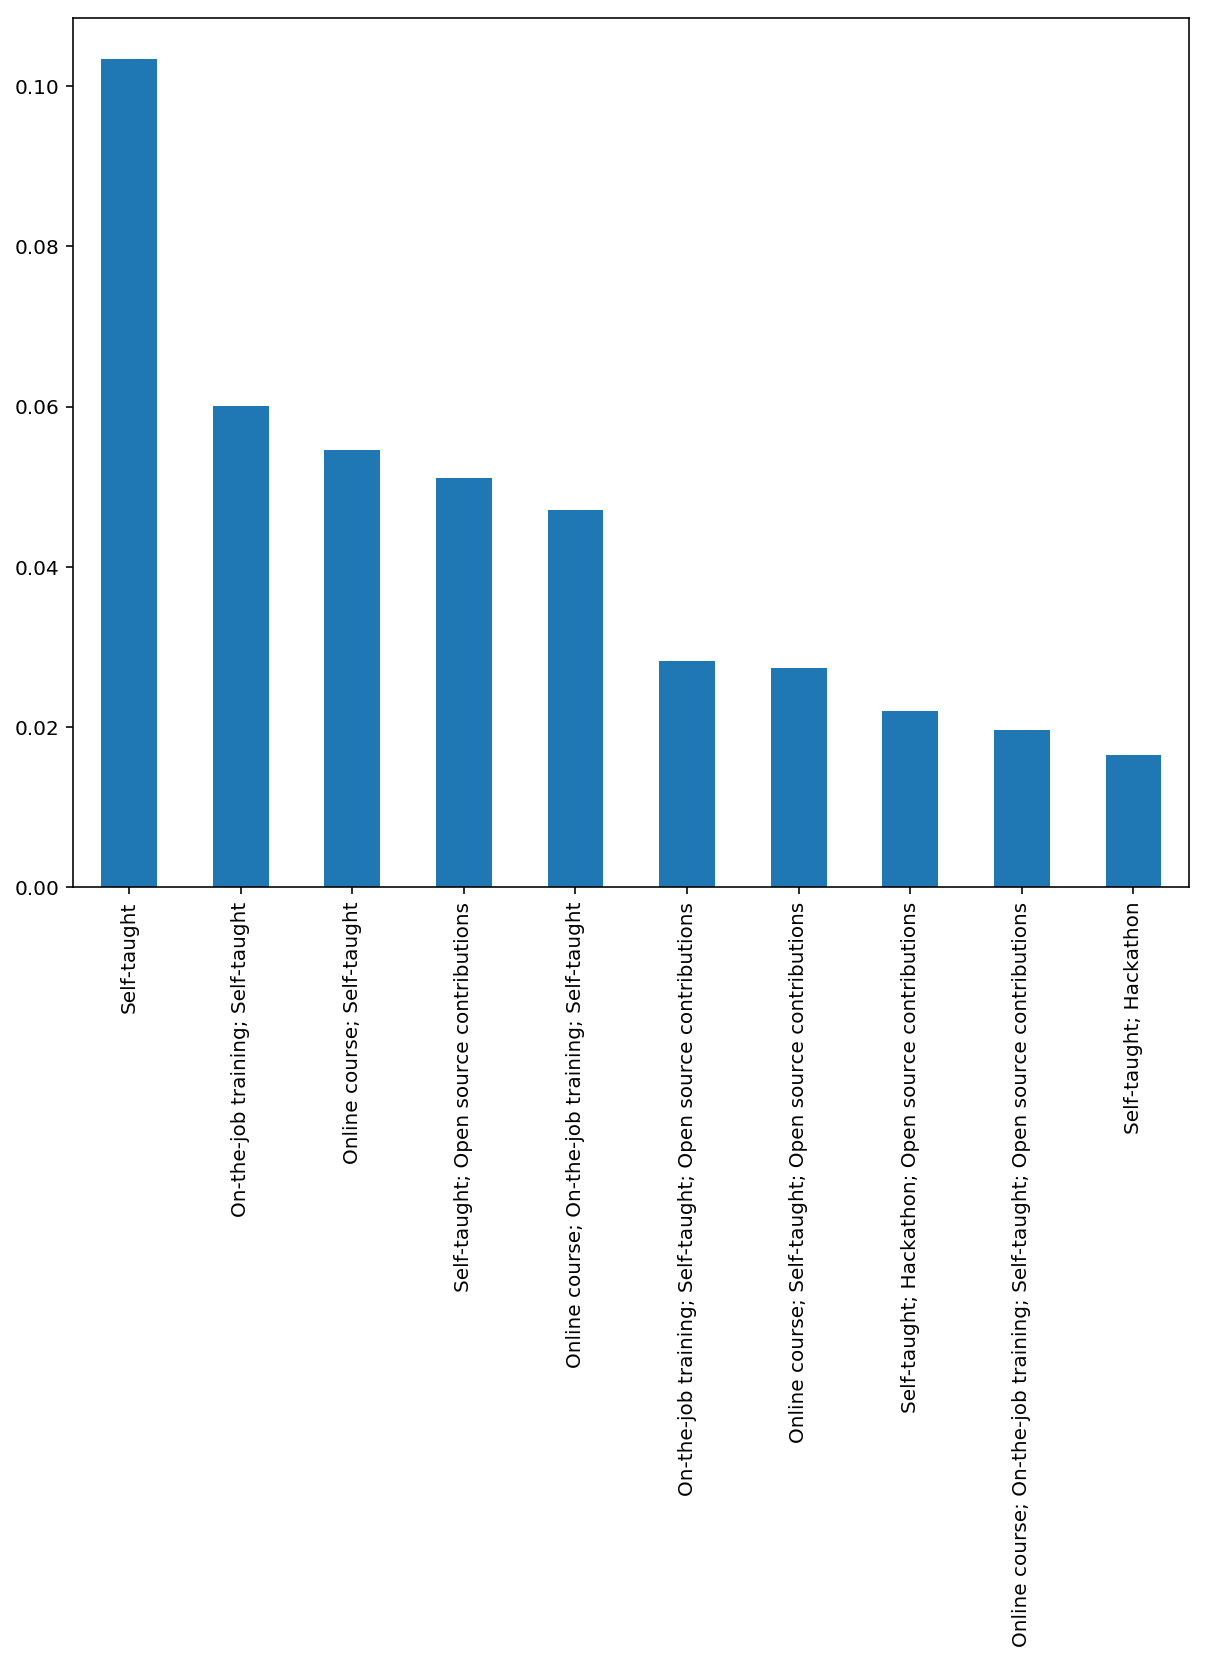

In [78]:
stack.EducationTypes.value_counts(normalize=True)[0:10].plot(kind='bar',figsize=(10,8))
plt.show()

## GIF vs JIF

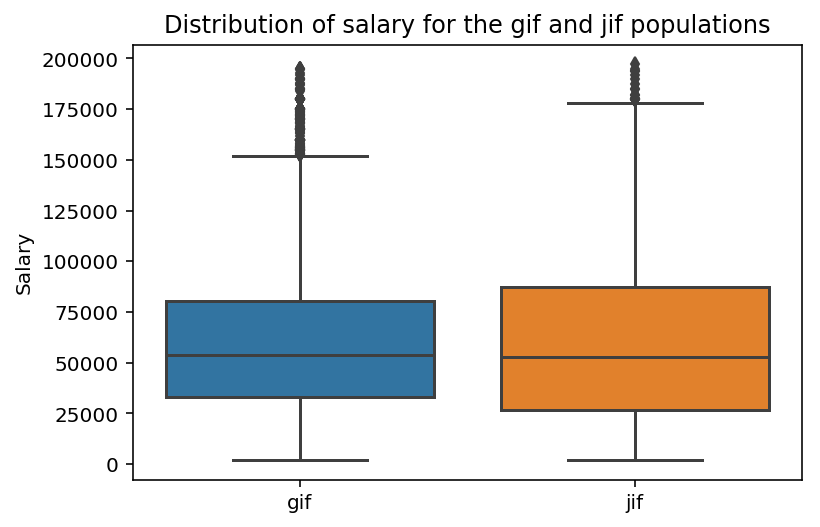

                 gif            jif
count    8765.000000    2896.000000
mean    59969.873023   60447.839240
std     37226.718306   42544.822205
min      2150.537634    2150.537634
25%     32954.545455   26881.720430
50%     53593.548387   53030.303030
75%     80645.161290   87500.000000
max    195000.000000  197000.000000


In [79]:
import matplotlib.pyplot as plt
temp = stack[["PronounceGIF", "Salary"]].dropna(how='any')
temp = temp.set_index("PronounceGIF")
gif = temp.loc['With a hard "g," like "gift"'].Salary.values
jif = temp.loc['With a soft "g," like "jiff"'].Salary.values
tr = pd.DataFrame()
tr['gif'] = pd.Series(gif)
filling = np.empty((6081))
filling[:] = np.nan
to_add = np.append(jif, filling)
tr['jif'] = pd.Series(to_add)
plot = sns.boxplot(data=tr, orient="v",)
plt.ylabel("Salary")
plt.title("Distribution of salary for the gif and jif populations")
plt.show()

print(tr.describe())